### Installation des packages :
Les packages ont ete installe via l'etape boostraping lors de l'intanciation du cluster
    

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import io 
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input 
from tensorflow.keras.preprocessing.image import img_to_array


from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col, udf, pandas_udf, PandasUDFType, element_at, split 

from pyspark.ml.linalg import Vectors, VectorUDT 
from pyspark.ml.feature import PCA

from pyspark.sql.types import ArrayType, StringType, FloatType

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1669107654286_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
S3_DATA_PATH = 's3://p8-oc-fruits/fruits-360-aws/' 
S3_PATH_RESULT = 's3://p8-results/resultats/'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Pas besoin d'Instancier d'une session spark ou d'un objet sparkcontext., ils sont automatiquement crees.
 

In [4]:
# spark = SparkSession.builder.config("spark.driver.memory", "50g").config("spark.executor.memory","50g").config('spark.driver.maxResultSize', '30g').appName('P8_OC_MC').getOrCreate()
# sc = spark.sparkContext

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [1]:
%%configure -f
{"conf":{"spark.driver.maxResultSize":"10G"}}

In [4]:
print(spark.conf.get('spark.driver.maxResultSize'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

10G

In [ ]:
%%info

## Chargement des donnees

In [5]:

images = spark.read.format("binaryFile").option("pathGlobFilter", "*.jpg").option("recursiveFileLookup", "true").load(S3_DATA_PATH) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://p8-oc-fruits...|2022-11-19 16:07:59|  7269|[FF D8 FF E0 00 1...|
|s3://p8-oc-fruits...|2022-11-19 16:08:47|  7204|[FF D8 FF E0 00 1...|
|s3://p8-oc-fruits...|2022-11-19 16:07:59|  7192|[FF D8 FF E0 00 1...|
|s3://p8-oc-fruits...|2022-11-19 16:08:46|  7144|[FF D8 FF E0 00 1...|
|s3://p8-oc-fruits...|2022-11-19 16:08:20|  7104|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

In [7]:
# Nombre d'image telechargees
images.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

653

In [8]:
# Ajouter une colonne 'label' des fruits
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
images.show(5, True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+--------------+
|                path|   modificationTime|length|             content|         label|
+--------------------+-------------------+------+--------------------+--------------+
|s3://p8-oc-fruits...|2022-11-19 16:07:59|  7269|[FF D8 FF E0 00 1...|     Raspberry|
|s3://p8-oc-fruits...|2022-11-19 16:08:47|  7204|[FF D8 FF E0 00 1...|Pineapple_Mini|
|s3://p8-oc-fruits...|2022-11-19 16:07:59|  7192|[FF D8 FF E0 00 1...|     Raspberry|
|s3://p8-oc-fruits...|2022-11-19 16:08:46|  7144|[FF D8 FF E0 00 1...|Pineapple_Mini|
|s3://p8-oc-fruits...|2022-11-19 16:08:20|  7104|[FF D8 FF E0 00 1...|Pineapple_Mini|
+--------------------+-------------------+------+--------------------+--------------+
only showing top 5 rows

## Extraction des Features des images avec CNN pre-entraines

Dans cette partie, on va réaliser un 'transfer learning' via InceptionV3 préentrainé comme un extracteur automatique de caractéristiques des images, matérialisé par le code CNN. On enlève la dernière couche - celle qui classifie - et on utilise donc la partie du code convolutif pour extraire ces features (caractéristiques). Une dernière couche en average pooling a été ajoutée.  
J'ai choisi Inception v3 pour sa performance et sa rapidité constatées dans le projet 6. C'est un réseau de neurones convolutif destiné à aider à l'analyse d'images et à la détection d'objets, et a débuté comme module pour GoogLeNet. Il s'agit de la troisième édition du réseau de neurones convolutif Inception de Google.  
Il est constitué de 48 couches profondes. Il prend en entrée une image en couleurs de taille 299 × 299 px. Ici on redimensionne pas les images qui sont 100x100 px


In [10]:
# Instanciation du modèle
model = InceptionV3(weights='imagenet', include_top=False,  pooling='avg')

# Résumé de l'architecture du modèle 
model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

87916544/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________

Pour l'extraction des features, j'ai suivi le tutorial detaillé de databricks disponible à l'adresse suivante:   
Source = https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html

Pour des tailles relativement moderées (< 1GB), databricks recommande de charger le modele sur le pilote (driver) puis à diffuser ensuite les poids aux différents espaces de travail (Executeurs).  

In [11]:
bc_model_weights = sc.broadcast(model.get_weights())

def fct_model():
    """
    Returns a InceptionV3 model with top layer removed, adding an average layer pooling and broadcasted pretrained weights
    """
    model = InceptionV3(weights=None, include_top=False, pooling='avg')
    model.set_weights(bc_model_weights.value)
    return model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# Define image loading and featurization logic in a Pandas UDF:The call stack is:

# pandas UDF
 # featurize a pd.Series of images
  # preprocess one image

def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    # BytesIO are methods that manipulate string and bytes data in memory
    img = Image.open(io.BytesIO(content))
    # Convertir les pixels en un tableau NumPy afin de pouvoir travailler avec dans Keras
    arr = img_to_array(img)
    return preprocess_input(arr)


def ser_extract_features(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # Flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)


@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def features_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.

    model = fct_model()
    for content_series in content_series_iter:
        yield ser_extract_features(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1669107654286_0001/container_1669107654286_0001_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

In [13]:
# Reducing the Arrow batch size via `maxRecordsPerBatch`(to avoid OutOfMemoryError)

spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# Features from fruits images

df_features = images.repartition(12).select(col("path"), col("label"), features_udf("content").alias("features"))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
df_features.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+--------------------+
|                path|       label|            features|
+--------------------+------------+--------------------+
|s3://p8-oc-fruits...|      Lychee|[0.0, 0.35864386,...|
|s3://p8-oc-fruits...|Cantaloupe_2|[1.0597609, 0.209...|
|s3://p8-oc-fruits...|  Strawberry|[1.2411461, 0.299...|
|s3://p8-oc-fruits...|    Pear_Red|[3.3436813, 0.605...|
|s3://p8-oc-fruits...|  Peach_Flat|[3.6528835, 1.122...|
+--------------------+------------+--------------------+
only showing top 5 rows

### Reduction ACP

In [16]:
# Convertir les features-arrays en Vecteurs denses pour la reduction ACP
features_vectors = udf(lambda x: Vectors.dense(x), VectorUDT())
vectorized_df = df_features.withColumn('cnn_vectors', features_vectors('features'))
vectorized_df.show(5, True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+--------------------+--------------------+
|                path|       label|            features|         cnn_vectors|
+--------------------+------------+--------------------+--------------------+
|s3://p8-oc-fruits...|      Lychee|[0.0, 0.35864386,...|[0.0,0.3586438596...|
|s3://p8-oc-fruits...|Cantaloupe_2|[1.0597609, 0.209...|[1.05976092815399...|
|s3://p8-oc-fruits...|  Strawberry|[1.2411461, 0.299...|[1.24114608764648...|
|s3://p8-oc-fruits...|    Pear_Red|[3.3436813, 0.605...|[3.34368133544921...|
|s3://p8-oc-fruits...|  Peach_Flat|[3.6528835, 1.122...|[3.65288352966308...|
+--------------------+------------+--------------------+--------------------+
only showing top 5 rows

In [17]:
vectorized_df.dtypes

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('path', 'string'), ('label', 'string'), ('features', 'array<float>'), ('cnn_vectors', 'vector')]

In [18]:
# # nombre de features par image (on le connait deja! mais pour etre sure?)
first_row = vectorized_df.select("features").take(1)
print(" le nombre de features par image est de: ", len(first_row[0][0]), "\n", 25*"====")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

 le nombre de features par image est de:  2048 

In [19]:
# Reduction ACP 

def red_acp(df):
    '''Réduction des dimensions PCA sur les features 
    Entrée:
    - features de l\'image    
    Retour:
    - pca
    - pca_matrix: résultat de la réduction de dimensions
    '''
    # selectionner colonnes 
    
    select_vec = df.select("path","label","cnn_vectors")
    
    pca = PCA(k=450, inputCol="cnn_vectors", outputCol="pca_features")  
    pca_mdl = pca.fit(select_vec)
    pca_results = pca_mdl.transform(select_vec)
   
    return pca_mdl, pca_results

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# Execution de la fonction de réduction de dimension PCA
pca_mdl, pca_results = red_acp(vectorized_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# display results
pca_results.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+--------------------+--------------------+
|                path|       label|         cnn_vectors|        pca_features|
+--------------------+------------+--------------------+--------------------+
|s3://p8-oc-fruits...|      Lychee|[0.0,0.3586438596...|[-12.253687031532...|
|s3://p8-oc-fruits...|Cantaloupe_2|[1.05976092815399...|[-15.914342389563...|
|s3://p8-oc-fruits...|  Strawberry|[1.24114608764648...|[-13.071387206247...|
|s3://p8-oc-fruits...|    Pear_Red|[3.34368133544921...|[-26.536181710366...|
|s3://p8-oc-fruits...|  Peach_Flat|[3.65288352966308...|[-33.701691079786...|
+--------------------+------------+--------------------+--------------------+
only showing top 5 rows

In [22]:
sum_var_pca = np.cumsum(pca_mdl.explainedVariance)
len(sum_var_pca)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

450

In [23]:
# plot cumsum

sum_var_pca = np.cumsum(pca_mdl.explainedVariance)

plt.figure(figsize=(12,8))
plt.title("Somme cumulee de variance des composantes de l'ACP")
plt.xlabel("Nombre de composantes de l'ACP")
plt.ylabel("Variance cumulee")

plt.plot(range(len(sum_var_pca)), sum_var_pca)
plt.axhline(y=0.99, color='r', linestyle='--')
plt.axhline(y=0.9, color='g', linestyle='--')

plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

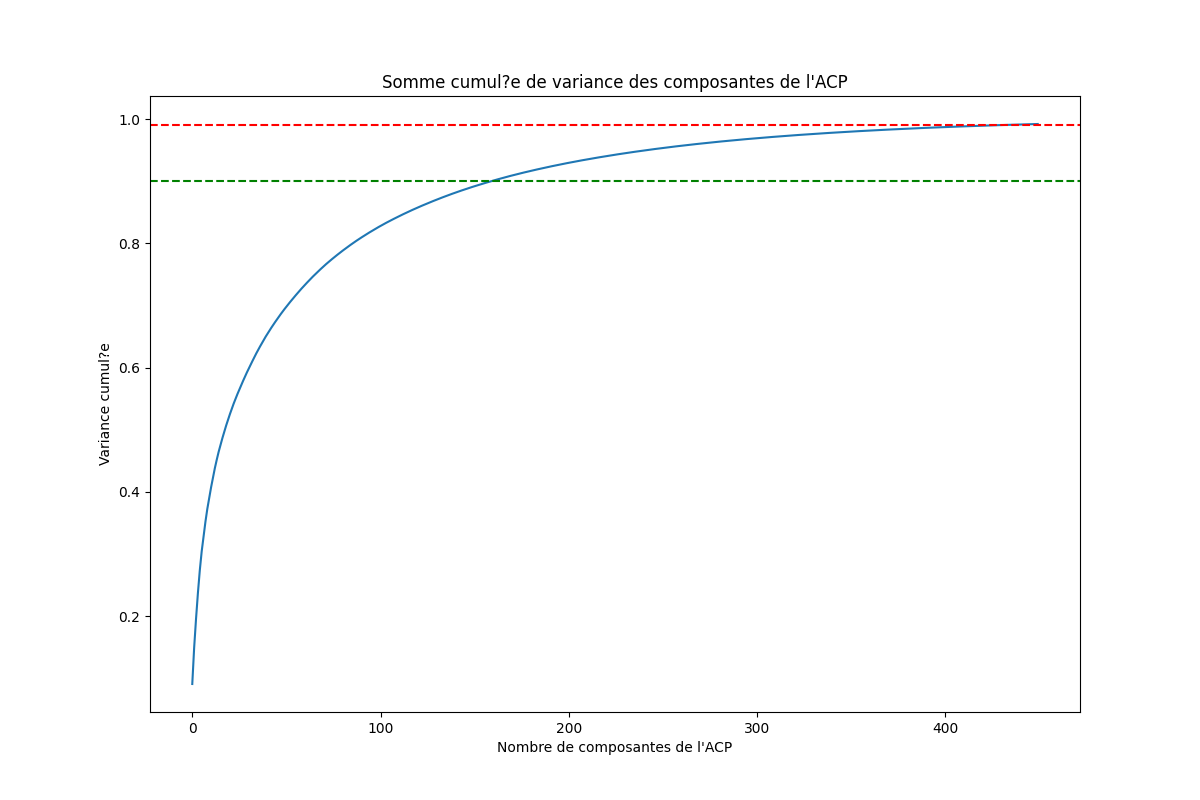

In [24]:
%matplot plt

In [29]:
# Transformation inverse (de Vectors à Arrays)

vector_to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

df_final = pca_results.withColumn('features_pca', vector_to_array('pca_features')).select('path', 'label','features_pca')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
df_final.show(5, True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+--------------------+
|                path|       label|        features_pca|
+--------------------+------------+--------------------+
|s3://p8-oc-fruits...|      Lychee|[-12.253687, 5.31...|
|s3://p8-oc-fruits...|Cantaloupe_2|[-15.914342, 2.79...|
|s3://p8-oc-fruits...|  Strawberry|[-13.071387, 8.62...|
|s3://p8-oc-fruits...|    Pear_Red|[-26.536182, 1.11...|
|s3://p8-oc-fruits...|  Peach_Flat|[-33.70169, 8.667...|
+--------------------+------------+--------------------+
only showing top 5 rows

### Sauvegarde des donnees au format parquet dans un bucket de S3

In [31]:
# Sauvegarde des donnees au format parquet dans S3

df_final.write.mode('overwrite').parquet(S3_PATH_RESULT)

# 20 parquets

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
# sauvegarde en format csv

format_udf = udf(lambda x: str(x), StringType()) 

df_csv = df_final.withColumn('features_pca', format_udf(col('features_pca')))

df_csv.write.mode("overwrite").option("delimiter", "\t").option("header","true").csv(S3_PATH_RESULT + "red_acp_incep.csv")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Chargement des données enregistrées et validation du résultat

In [33]:
df = spark.read.parquet(S3_PATH_RESULT)
df = df.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
df.head(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                       features_pca
0  s3://p8-oc-fruits/fruits-360-aws/Lychee/184_10...  ...  [-13.381126403808594, 6.015714645385742, 3.960...
1  s3://p8-oc-fruits/fruits-360-aws/Nectarine/r_2...  ...  [-46.47102355957031, 5.452133655548096, 13.126...
2  s3://p8-oc-fruits/fruits-360-aws/Limes/r_116_1...  ...  [-29.132219314575195, 5.515618801116943, 19.29...
3  s3://p8-oc-fruits/fruits-360-aws/Pepper_Red/r2...  ...  [-18.10908317565918, 7.919822692871094, 13.732...
4  s3://p8-oc-fruits/fruits-360-aws/Nectarine/r_2...  ...  [-58.964073181152344, 7.574435710906982, 22.68...

[5 rows x 3 columns]

### Arrêt de la session Spark

In [35]:
# Arrêt de la session Spark
spark.stop()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### END